In [3]:
from MVN import MultivariateNormal
from MCMC import MetropolisHastings, Gibbs, Cholesky, SampleSet2D
from multiple_chains import MultipleChains, errors_sampler, plot_errors
from tqdm import tqdm

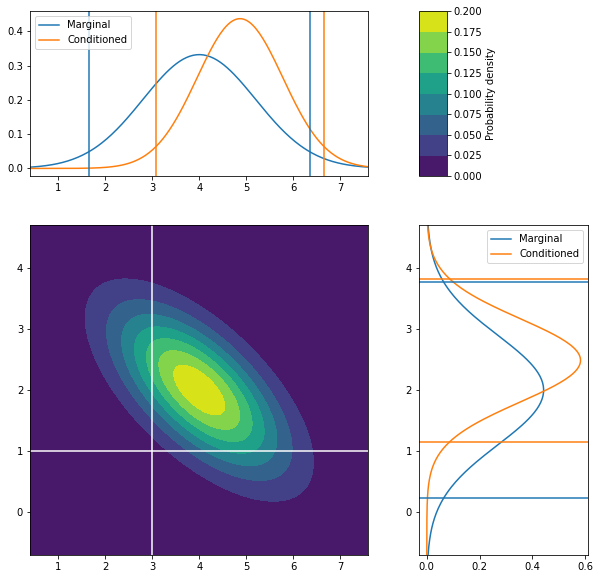

In [4]:
mean = np.array([4, 2])
covariance = np.array([
    [1.44, -.702],
    [-.702, .81]])

CL = .95

n = MultivariateNormal(mean, covariance)
# this class, defined in a separate file, has all the properties we need

n.plot_2d_analytical(3, 1, CL)
# bivariate plot of the Gaussian, including marginal distributions
# and conditioned distributions on the values provided as arguments
# and credible intervals for each univariate Gaussian 

In [5]:
# Let us see some numbers

mx = n.marginalize(0)
CI_x_analytical = mx.analytical_CI(CL)
my = n.marginalize(1)
CI_y_analytical = my.analytical_CI(CL)
print(f'The Credible Interval for x is between {CI_x_analytical[0]:.2f} and {CI_x_analytical[1]:.2f}')
print(f'The Credible Interval for y is between {CI_y_analytical[0]:.2f} and {CI_y_analytical[1]:.2f}')

The Credible Interval for x is between 1.65 and 6.35
The Credible Interval for y is between 0.24 and 3.76


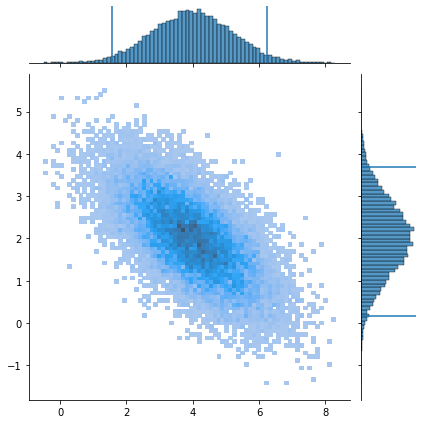

In [6]:
# CHOLESKY SAMPLING

samples_ch = SampleSet2D(n.cholesky_sample(20000))
samples_ch.samples_plot(.95, kind='hist')

In [7]:
# METROPOLIS - HASTINGS SAMPLING

# def gaussian_proposal(theta=None):
#     return (np.random.normal(scale=1, size=2))
from numpy.random import default_rng

def gaussian_proposal(theta=None):
    rng = default_rng()
    return(rng.standard_normal(size=2))

num_chains = 7
spread_initial_positions = 10
initial_positions = np.random.normal(scale=spread_initial_positions, size=(num_chains, 2))

chain_length = 200

mh = MultipleChains(MetropolisHastings, n.pdf, initial_positions,
                       chain_length, gaussian_proposal)

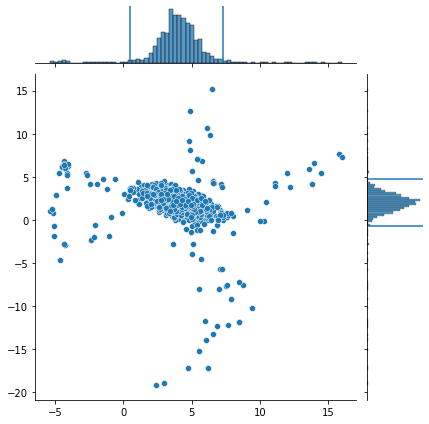

In [8]:
samples_mh = SampleSet2D(mh.all_chains)
samples_mh.samples_plot(CL, kind='scatter')

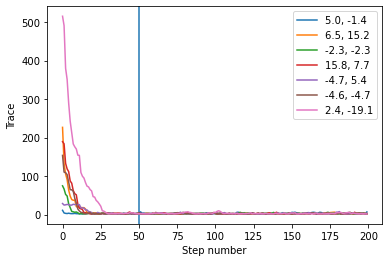

In [9]:
plt.axvline(mh.optimal_trimming)
mh.traces_plot(every=1)

In [10]:
mh.trim_chains(mh.optimal_trimming)
mh.extend_chains(int(1e4))

Trimming at 50


In [11]:
print(mh.R_estimator()) # < 1.02 in all its entries!
print(mh.autocorrelation_times()) # all close to 1! great
# am I underestimating these?

[[1.00073909 1.00133749]
 [1.00133749 1.00092029]]
[1.0006886648666917, 1.0013512286244068, 1.0004564889252108, 1.0006832511379928, 1.0004069379462557, 1.0012603352716607, 1.0007814293380703]


In [12]:
# SampleSet2D(mh.all_chains).samples_plot(CL, kind='kde')

In [13]:
# GIBBS SAMPLING
# from our distribution n

def conditional(i, theta):
    rng = default_rng()
    deviate = rng.standard_normal()
    
    conditioned = n.condition(i, theta[1-i])
    sigma = np.sqrt(conditioned.cov)
    return((conditioned.mean + sigma * deviate)[0,0])

g = MultipleChains(Gibbs, n.pdf, initial_positions, chain_length, conditional)


Trimming at 4


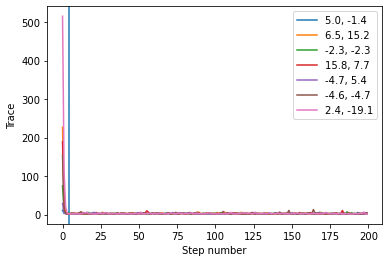

In [14]:
plt.axvline(g.optimal_trimming)
g.traces_plot(every=1)
g.trim_chains(g.optimal_trimming)

In [15]:
g.extend_chains(int(1e3))

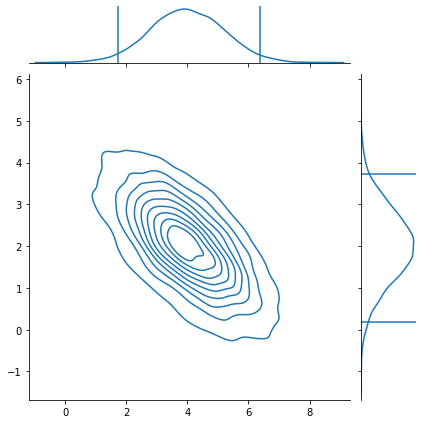

In [16]:
SampleSet2D(g.all_chains).samples_plot(CL, kind='kde')

In [29]:
chain_length = 10
def gaussian_proposal_2(theta=None):
    rng = default_rng()
    return(rng.standard_normal(size=2) / 5)

# mc_1 = MultipleChains(Gibbs, n.pdf, initial_positions[:5], chain_length, conditional)
mc_1 = MultipleChains(MetropolisHastings, n.pdf, initial_positions[:5], chain_length, gaussian_proposal_2)
# mc_1 = MultipleChains(Cholesky, n.pdf, initial_positions, chain_length, n.cholesky_sample)

trimming_index = 40
N, e_mean, e_cov = errors_sampler(mc_1, n, max_num=int(5e6), trimming_index=trimming_index)

39it [00:04, 11.95it/s]Trimming at 84
200it [18:26,  5.53s/it]


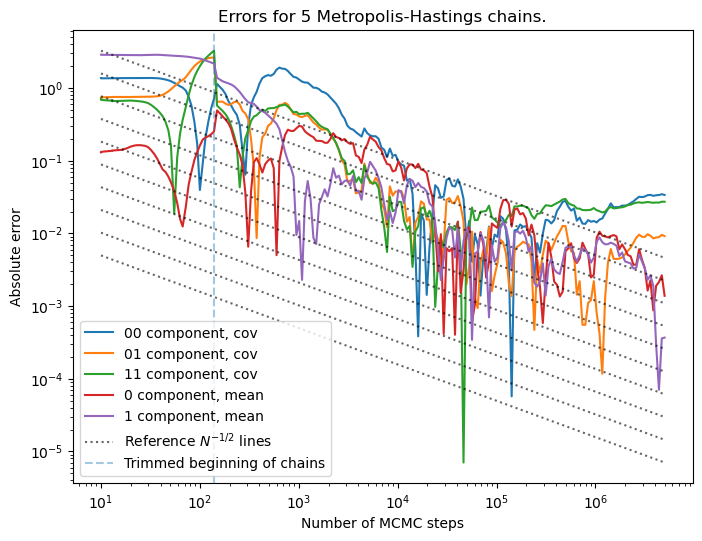

In [30]:
plot_errors(N, e_mean, e_cov, mc_1, trimming_index=trimming_index)
plt.savefig('errors_mh_sigma_02.pdf')

In [19]:
SS = SampleSet2D(g.all_chains)
x, y, z = SS.kde()

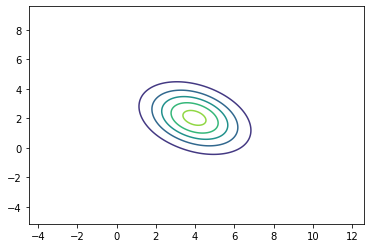

In [20]:
plt.contour(x, y, z)

In [21]:
yc, zc = SS.conditional_kde(0, 1)
cs = SS.conditional_cut(0, 1, .2)

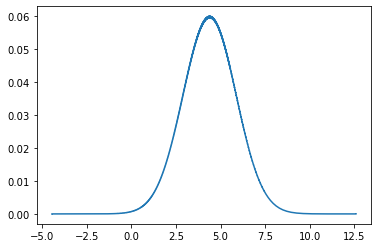

In [22]:
plt.plot(yc, zc)

(array([  1.,   1.,   2.,   6.,  19.,  22.,  50.,  74.,  98., 120.,  97.,
        109.,  59.,  36.,  21.,   9.,   4.,   1.,   1.,   1.]),
 array([1.45077531, 1.80449753, 2.15821975, 2.51194197, 2.8656642 ,
        3.21938642, 3.57310864, 3.92683086, 4.28055309, 4.63427531,
        4.98799753, 5.34171975, 5.69544198, 6.0491642 , 6.40288642,
        6.75660864, 7.11033087, 7.46405309, 7.81777531, 8.17149753,
        8.52521976]),
 <BarContainer object of 20 artists>)

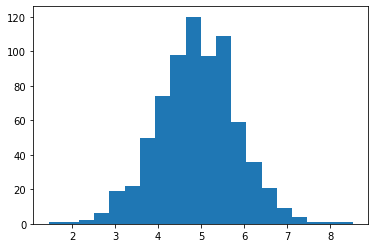

In [23]:
plt.hist(cs[:,0], bins=20)

In [24]:
cs.shape

(731, 2)